### 資料來源 : https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


匯入必要模組和函式庫

In [ ]:
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from collections import Counter
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

獲取影像檔案路徑並計算影像數量
- 定義函式 get_image_filepaths，用於獲取指定目錄中所有 .jpg 格式的影像檔案路徑
- 計算訓練、測試和驗證資料集中影像的數量

In [16]:
def get_image_filepaths(directory): # directory 是一個用於指定目錄的變數
    return list(Path(directory).glob(r'**/*.jpg'))

print('training images:',len(get_image_filepaths('/content/drive/MyDrive/3.Python深度學習應用開發/03_水果/train')))
print('testing images:',len(get_image_filepaths('/content/drive/MyDrive/3.Python深度學習應用開發/03_水果/test')))
print('validation images:',len(get_image_filepaths('/content/drive/MyDrive/3.Python深度學習應用開發/03_水果/validation')))

training images: 2780
testing images: 334
validation images: 334


處理影像檔案路徑並生成數據框
- 取得訓練、測試和驗證資料集中所有影像的路徑
- 定義函式 proc_img，用於處理這些影像路徑並生成包含文件路徑和標籤的數據框

In [ ]:
# 取得所有圖片的路徑
train_filepaths = get_image_filepaths('/content/drive/MyDrive/3.Python深度學習應用開發/03_水果/train')
test_filepaths = get_image_filepaths('/content/drive/MyDrive/3.Python深度學習應用開發/03_水果/test')
val_filepaths = get_image_filepaths('/content/drive/MyDrive/3.Python深度學習應用開發/03_水果/validation')

def proc_img(filepaths):
    data = [] # 創建一個空列表，用於存儲文件路徑和標籤
    for filepath in filepaths:
        label = filepath.parent.name # 獲取文件路徑的父目錄名稱(即標籤)
        data.append({'Filepath':str(filepath),'Label':label}) # 將文件路徑和標籤添加到data列表中
    return pd.DataFrame(data)

# 生成訓練、測試和驗證數據框
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

獲取影像標籤並計算資料集分佈
- 從影像檔案路徑中提取標籤，並計算訓練、測試和驗證資料集中每個標籤的分佈情況

In [18]:
# path.parent.name 可以取得資料夾名稱，filepaths 是一個 list
train_labels = [path.parent.name for path in train_filepaths]
test_labels = [path.parent.name for path in test_filepaths]
val_labels = [path.parent.name for path in val_filepaths]

print('Training set distribution:',Counter(train_labels))
print('Testing set distribution:',Counter(test_labels))
print('Validation set distribution:',Counter(val_labels))

Training set distribution: Counter({'soy beans': 92, 'peas': 90, 'spinach': 87, 'lettuce': 87, 'turnip': 85, 'grapes': 85, 'tomato': 84, 'pineapple': 84, 'cabbage': 84, 'beetroot': 84, 'corn': 84, 'sweetcorn': 83, 'garlic': 83, 'kiwi': 82, 'onion': 80, 'capsicum': 80, 'watermelon': 79, 'jalepeno': 79, 'cucumber': 78, 'bell pepper': 78, 'mango': 77, 'eggplant': 77, 'pear': 76, 'chilli pepper': 76, 'paprika': 74, 'pomegranate': 74, 'carrot': 73, 'cauliflower': 71, 'raddish': 70, 'sweetpotato': 69, 'potato': 66, 'ginger': 64, 'lemon': 64, 'banana': 62, 'orange': 61, 'apple': 58})
Testing set distribution: Counter({'sweetcorn': 10, 'tomato': 10, 'watermelon': 10, 'soy beans': 10, 'sweetpotato': 10, 'turnip': 10, 'spinach': 10, 'pear': 10, 'pineapple': 10, 'pomegranate': 10, 'paprika': 10, 'mango': 10, 'eggplant': 10, 'kiwi': 10, 'ginger': 10, 'cucumber': 10, 'corn': 10, 'garlic': 10, 'beetroot': 10, 'cabbage': 10, 'peas': 9, 'lettuce': 9, 'potato': 9, 'onion': 9, 'jalepeno': 9, 'bell peppe

顯示每個類別的第一張圖像
- 創建一個字典來存儲每個類別的第一張影像，並使用 Matplotlib 顯示這些影像

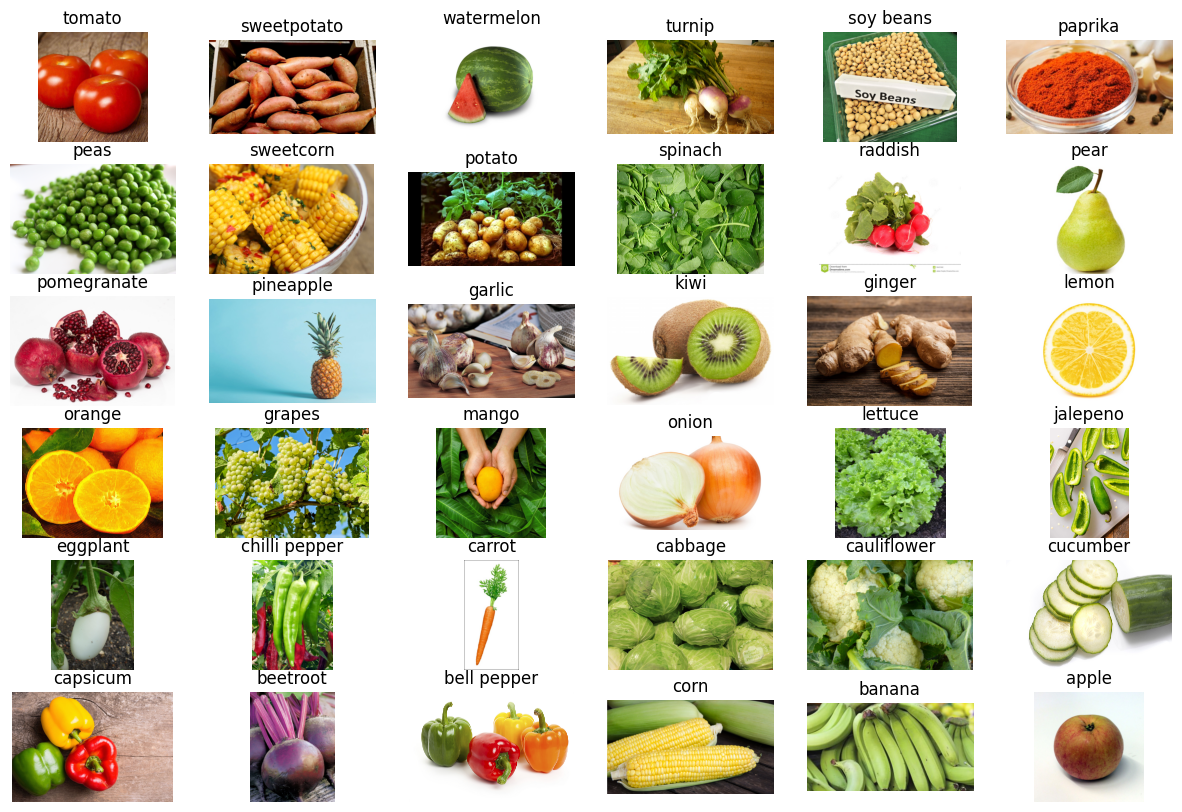

In [ ]:
first_images = {}
for category in train_df['Label'].unique():
    first_images[category] = train_df[train_df['Label'] == category]['Filepath'].values[0]

plt.figure(figsize=(15,10))
for i, (category, image_path) in enumerate(first_images.items()):
    image = Image.open(image_path)
    plt.subplot(6,6,i+1) # i+1 是因為 subplot 從 1 開始
    plt.imshow(image)
    plt.title(category)
    plt.axis('off')

plt.show()

創建影像數據生成器進行數據增強和預處理

In [ ]:
# 使用 ImageDataGenerator 進行數據增強

train_datagen = ImageDataGenerator(
    rescale=1./255, # 將像素值縮放到 [0, 1] 之間
    rotation_range=40, # 隨機旋轉圖片
    width_shift_range=0.2, # 隨機水平平移
    height_shift_range=0.2, # 隨機垂直平移
    shear_range=0.2, # 隨機剪切(沿某個方向傾斜)
    zoom_range=0.2, # 隨機縮放
    horizontal_flip=True, # 隨機水平翻轉
    brightness_range=[0.8, 1.2], # 隨機調整亮度
    channel_shift_range=0.2, # 隨機改變顏色通道
    fill_mode='nearest' # 填充新創建像素的方法
)

# 創建 ImageDataGenerator 用於驗證和測試數據集（不進行增強）
test_datagen = ImageDataGenerator(rescale=1./255)

# 創建數據生成器
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical' # 使用 categorical_crossentropy 損失函數
)

val_generator = test_datagen.flow_from_dataframe(
    val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# 在創建數據生成器之前打亂數據框
test_df = test_df.sample(frac=1).reset_index(drop=True)

# 重新創建數據生成器
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


'\n2855 表示在 train_df DataFrame 中找到了 2855 個有效的圖像文件。\n36 classes 表示這些圖像文件屬於 36 個不同的類別。\n'

載入並配置預訓練模型 MobileNetV2

In [ ]:
# 載入預訓練模型
base_model = MobileNetV2(
    input_shape=(224,224,3), # 輸入圖像的形狀
    include_top=False, # 不包含頂層的全連接層
    weights='imagenet', # 使用 ImageNet 預訓練權重
    pooling='avg' # 全局平均池化
)
base_model.trainable = False

# 顯示模型摘要
# base_model.summary()

建立並訓練影像分類模型

In [ ]:
# 建立模型
input = base_model.input
x = layers.Dense(512,activation='relu')(base_model.output)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dense(64,activation='relu')(x)
output = layers.Dense(36,activation='softmax')(x)

model = models.Model(inputs=input,outputs=output)

# 編譯模型
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 設置回調函數
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/3.Python深度學習應用開發/03_水果/fruit_model.keras',
        save_best_only=True, # 只儲存性能最好的模型（根據監控指標）
        monitor='val_accuracy', # 監控驗證集的準確率
        mode='max' # 當 val_accuracy 最大時，儲存模型
    )
]

# 訓練模型
history = model.fit(train_generator, # 使用訓練集數據
                    validation_data=val_generator, # 使用驗證集數據
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.2390 - loss: 2.8723 - val_accuracy: 0.7605 - val_loss: 0.9004
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6554 - loss: 1.1117 - val_accuracy: 0.8054 - val_loss: 0.6037
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.7465 - loss: 0.7687 - val_accuracy: 0.8533 - val_loss: 0.4380
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7940 - loss: 0.6681 - val_accuracy: 0.8802 - val_loss: 0.3925
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.7965 - loss: 0.6167 - val_accuracy: 0.8802 - val_loss: 0.3505
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8471 - loss: 0.4418 - val_accuracy: 0.8832 - val_loss: 0.3153
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8533 - loss: 0.4350 - val_accuracy: 0.8922 - val_loss: 0.3279
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8456 - loss: 0.4437 - val_accuracy: 0.8653 - val_loss: 0.

視覺化模型訓練過程中的準確率和損失
- 將模型訓練過程中的準確率和損失數據轉換為 DataFrame
- 使用 Matplotlib 繪製出訓練和驗證過程中的準確率和損失曲線

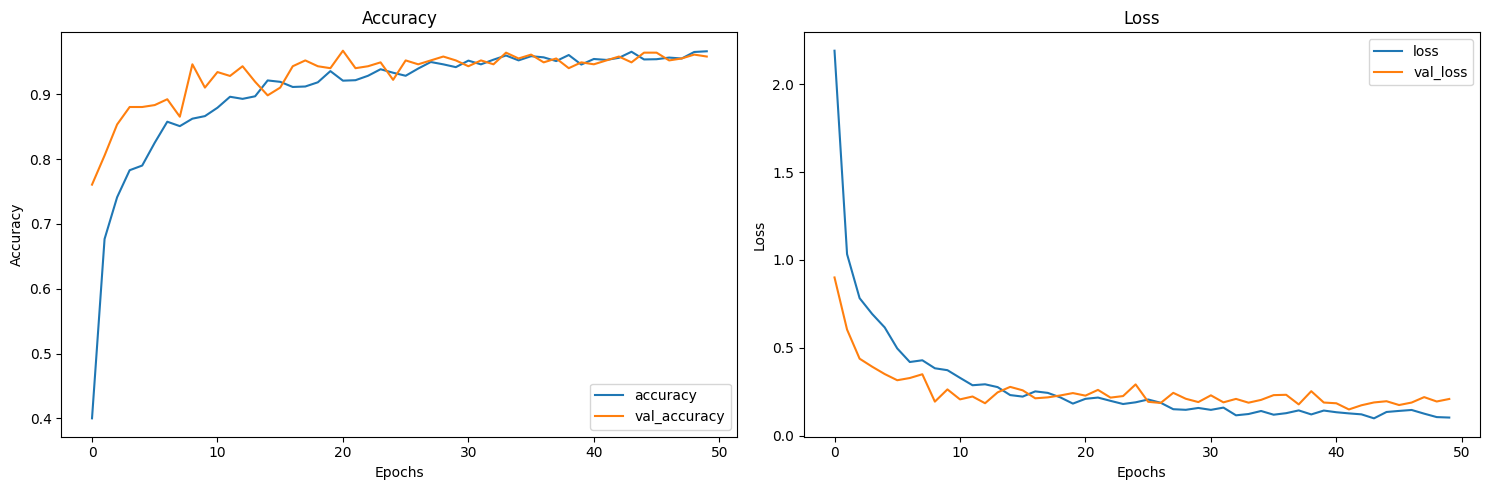

In [ ]:
# 將訓練歷史轉換為 DataFrame
result = pd.DataFrame(history.history)

# 創建子圖
fig, axes = plt.subplots(1,2,figsize=(15, 5))

# 繪製準確率曲線
result[['accuracy','val_accuracy']].plot(ax=axes[0])
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")

# 繪製損失曲線
result[['loss','val_loss']].plot(ax=axes[1])
axes[1].set_title("Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")

# 調整佈局並顯示圖表
plt.tight_layout()
plt.show()

獲取並顯示標籤對應表

In [ ]:
# 獲取標籤對應表
label_map = train_generator.class_indices

# 反轉字典以便於查詢
label_map = {v:k for k, v in label_map.items()}

# 顯示標籤對應表
print(label_map)

{0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}


載入最佳模型並使用測試數據進行預測

In [ ]:
# 載入最佳模型
model = tf.keras.models.load_model('/content/drive/MyDrive/3.Python深度學習應用開發/03_水果/fruit_model.keras')

# 使用測試數據生成器進行預測
test_loss,test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy:{test_accuracy * 100:.2f}%')

# 獲取預測結果
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions,axis=1)

# 顯示前10個預測結果和實際結果
predicted_labels = [label_map[i] for i in predicted_classes[:10]]
actual_labels = [label_map[i] for i in test_generator.classes[:10]]

print("Predicted labels:",predicted_labels)
print("Actual labels:",actual_labels)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9727 - loss: 0.2778
Test accuracy: 96.71%
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
Predicted labels: ['cabbage', 'turnip', 'cabbage', 'pineapple', 'turnip', 'garlic', 'bell pepper', 'raddish', 'orange', 'beetroot']
Actual labels:    ['cabbage', 'turnip', 'cabbage', 'pineapple', 'turnip', 'garlic', 'bell pepper', 'raddish', 'orange', 'beetroot']


顯示混淆矩陣
- 評估模型在測試數據上的預測效果

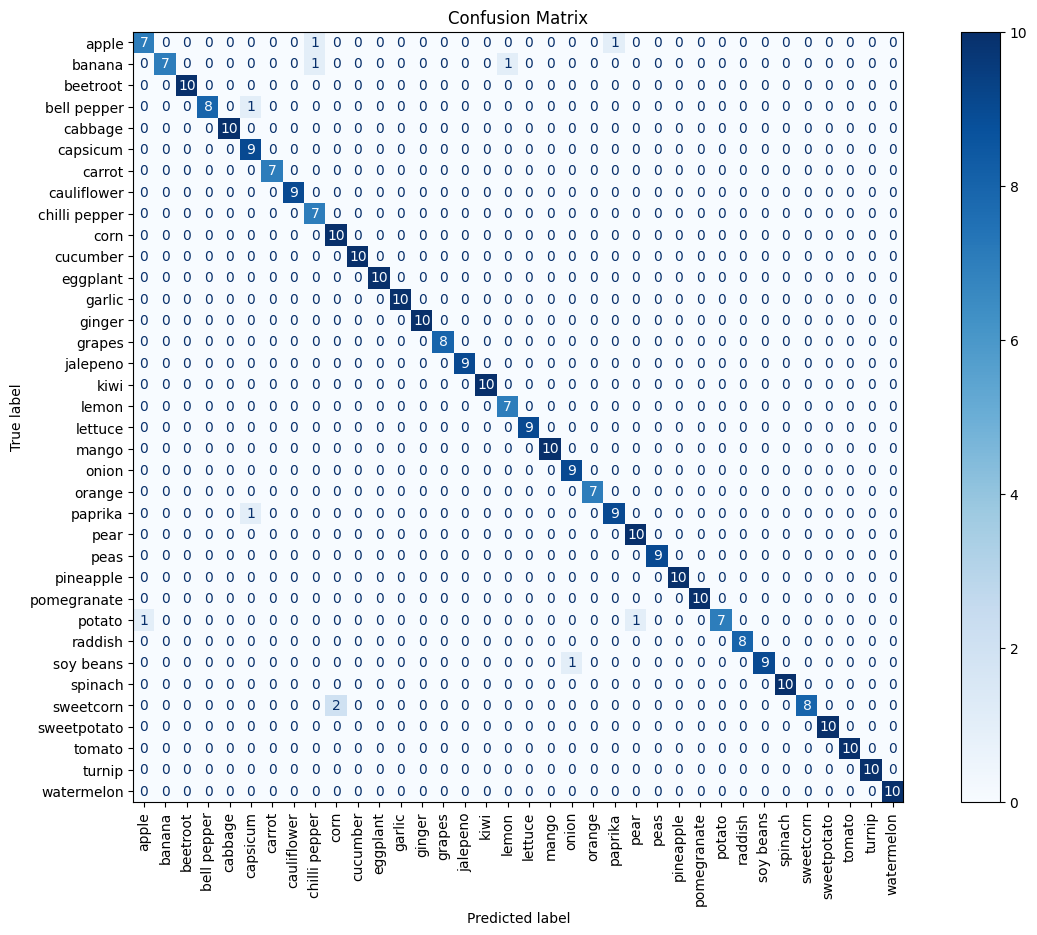

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_classes = test_generator.classes
pred_classes = predicted_classes

# 產生混淆矩陣
cm = confusion_matrix(true_classes,pred_classes)

# 顯示混淆矩陣
fig,ax = plt.subplots(figsize=(15,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues,ax=ax)

# 自定義圖形
plt.xticks(rotation=90)  # 旋轉 x 軸標籤以提高可讀性
plt.title('Confusion Matrix')
plt.show()